# Training detection model to find task numbers using Detectron2

# Install detectron2

In [1]:
# install dependencies: 
#!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

# What version of Python do you have?
import sys
import platform
import torch
import pandas as pd
import sklearn as sk

has_gpu = torch.cuda.is_available()
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

2.0.0 False


46.30s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Apple clang version 14.0.0 (clang-1400.0.29.202)
Target: arm64-apple-darwin22.3.0
Thread model: posix
InstalledDir: /Library/Developer/CommandLineTools/usr/bin
Python Platform: macOS-13.2.1-arm64-arm-64bit
PyTorch Version: 2.0.0

Python 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:38:11) 
[Clang 14.0.6 ]
Pandas 1.5.3
Scikit-Learn 1.2.1
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


In [2]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
torch.device("mps")     # for Apple Metal
#import detectron2
#assert torch.__version__.startswith("1.7")     # for colab
#!python -m pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

device(type='mps')

### Don't forget to install Detectron2
```
git clone https://github.com/facebookresearch/detectron2.git
python -m pip install -e detectron2
```

In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random, scipy
# from google.colab.patches import cv2_imshow
from IPython import display
import PIL


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


def cv2_imshow(a):
    """A replacement for cv2.imshow() for use in Jupyter notebooks.
    Args:
    a : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. 
    shape (N, M, 3) is an NxM BGR color image. shape (N, M, 4) is an NxM BGRA color image.
    """
    a = a.clip(0, 255).astype('uint8')
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display.display(PIL.Image.fromarray(a))

# Train on a custom dataset

### Generate segmentation part for COCO format

In [4]:
#### Not used: Our dataset already split 1 mask for each mask file
'''
Create separate mask images list from a mask file.
The detectron2 dataset requires a mask dictionary for each instance, but
a mask file can have multiple masks.
ref: https://stackoverflow.com/questions/57192138/how-to-create-separate-images-containing-one-instance-mask-per-image-from-a-sing
param filename: Path to image which has corresponding mask image
returns: list of separate mask images which are 
of same size and only have 1 mask each. 
each image is a numpy array of dtype int64.
'''
def create_separate_masks(filename):
    # get matching mask file path
    mask_path = filename.replace("images", "segs")
    # get mask image
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    masks_list = []

    # get masks labelled with different values
    label_im, nb_labels = scipy.ndimage.label(mask) 

    for i in range(nb_labels):

        # create an array which size is same as the mask but filled with 
        # values that we get from the label_im. 
        # If there are three masks, then the pixels are labeled 
        # as 1, 2 and 3.

        mask_compare = np.full(np.shape(label_im), i+1) 

        # check equality test and have the value 1 on the location of each mask
        separate_mask = np.equal(label_im, mask_compare).astype(int) 

        # replace 1 with 255 for visualization as rgb image

        separate_mask[separate_mask == 1] = 255 

        masks_list.append(separate_mask)
    return masks_list

In [5]:
# use pycocotools to do mask encoding
import pycocotools
import pycocotools._mask as _mask
'''
Create an image's segmentation mask dictionary to
match detectron2 custom format. ref:
https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html
param img: mask image containing only 1 instance
returns: per-pixel segmentation mask in COCO's compressed RLE format
'''
def get_mask_as_dict(img):
    # convert grayscale image to have one more channel since mask encoding
    # needs 3 dimensional image, ex. (773, 739, 1)
    height, width = img.shape
    img_reshaped = img.reshape(height, width, 1)
    # read the mask image and convert to image with only 0's and 1's.
    # Surrounding area is 0, mask is 1
    binary_mask = np.where(img_reshaped > 0, 1, 0)
    # cast binary mask int64 to uint8
    binary_mask = binary_mask.astype(np.uint8)
    # convert a uint8 segmentation mask of 0s and 1s into dict by
    # using pycocotools
    mask_as_dict = pycocotools._mask.encode(np.asarray(binary_mask, order="F"))
    return mask_as_dict

In [6]:
import json
import numpy as np
from pycocotools import mask
from skimage import measure
'''
Create an image's segmentation mask as polygon list to
match detectron2 custom format.
ref: https://github.com/cocodataset/cocoapi/issues/131
param img: mask image containing only 1 instance
returns: list[list[float]], 
it represents a list of polygons, one for each connected component of the object.
'''
def get_mask_as_polygon_list(img):
  segmentation_list = []

  height, width = img.shape
  binary_mask = np.where(img > 0, 1, 0)
  # cast binary mask int64 to uint8
  binary_mask = binary_mask.astype(np.uint8)
  fortran_ground_truth_binary_mask = np.asfortranarray(binary_mask)
  contours = measure.find_contours(binary_mask, 0.5)

  for contour in contours:
      contour = np.flip(contour, axis=1)
      segmentation = contour.ravel().tolist()
      segmentation_list.append(segmentation)

  return segmentation_list

In [7]:
'''
Get bounding box from a compressed mask image dictionary
param compressed_mask: per-pixel segmentation mask in COCO's compressed RLE format
returns: one box in format [xmin, ymin, xmax, ymax]
'''
def get_box_from_compressed(compressed_mask, mode=False):   # mode false = XYWH, true = XYXY
    # bounding boxes, which is a list of boxes. each box is coordinate list.
    # Since there is 1 mask, there should only be 1 box in COCO format.
    # [top left x position, top left y position, width, height]
    # example boxes: [[665.  35.  60.  54.]]
    boxes = pycocotools._mask.toBbox(compressed_mask)
    assert len(boxes) == 1
    box = boxes[0]
    
    xmin = int(box[0])
    ymin = int(box[1])
    if mode:
        # For XYXY bbox mode
        xmax = int(xmin + box[2])
        ymax = int(ymin + box[3])
        return [xmin, ymin, xmax, ymax]
    else:
    # For XYWH bbox mode
        w = int(box[2])
        h = int(box[3])
    return [xmin, ymin, w, h]

In [8]:
## Test output
path = 'datasets/stage1_train/1H_Nrf2_No_ADT_5_DAPI_1_0/masks/ADT_0_1_1.png'
img = cv2.imread(path, 0)
mask = get_mask_as_dict(img)
bb = get_box_from_compressed(mask)
par = get_mask_as_polygon_list(img)
print('Mask: {}'.format(mask))
print('Bounding Box: {}'.format(bb))
print('Polygon: {}'.format(par))

Mask: [{'size': [255, 319], 'counts': b'akQ14e77N100000000001O1N3LPkZ1'}]
Bounding Box: [135, 241, 11, 12]
Polygon: [[143.0, 252.5, 142.0, 252.5, 141.0, 252.5, 140.0, 252.5, 139.0, 252.5, 138.0, 252.5, 137.0, 252.5, 136.0, 252.5, 135.5, 252.0, 135.0, 251.5, 134.5, 251.0, 134.5, 250.0, 134.5, 249.0, 134.5, 248.0, 135.0, 247.5, 135.5, 247.0, 135.5, 246.0, 135.5, 245.0, 135.5, 244.0, 135.5, 243.0, 135.5, 242.0, 136.0, 241.5, 136.5, 241.0, 137.0, 240.5, 138.0, 240.5, 139.0, 240.5, 140.0, 240.5, 141.0, 240.5, 142.0, 240.5, 142.5, 241.0, 143.0, 241.5, 143.5, 242.0, 144.0, 242.5, 144.5, 243.0, 144.5, 244.0, 145.0, 244.5, 145.5, 245.0, 145.5, 246.0, 145.5, 247.0, 145.5, 248.0, 145.5, 249.0, 145.0, 249.5, 144.5, 250.0, 144.5, 251.0, 144.0, 251.5, 143.5, 252.0, 143.0, 252.5]]


In [9]:
from detectron2.structures import BoxMode
'''
Create annotations list of dictionaries required by
detectron2 instance segmentation dataset format.
param masks_list: list of individual mask images, with 1 mask per image.
returns: list of dictionaries, where each dictionary represents 1 instance
and contains the keys: 
    - bbox (list[float], required)
    - bbox_mode (int, required)
    - category_id (int, required)
    - segmentation (dict)
'''
def get_annotations(mask, mode=False):  # mode false = XYWH, true = XYXY
    # only used to get bounding boxes
    seg_dict = get_mask_as_dict(mask)
    box = get_box_from_compressed(seg_dict, mode)
    if mode:
        bbox_mode = BoxMode.XYXY_ABS
    else:
        bbox_mode = BoxMode.XYWH_ABS
    seg_poly_list = get_mask_as_polygon_list(mask)

    # category_id = 0 since background is 1
    obj = {
    "bbox": box,
    "bbox_mode": bbox_mode,
    "segmentation": seg_poly_list,
    "category_id": 0,
    }

    return obj

#### Create Dataframe of file path to easily manage

In [10]:
keywords = {
    '1H_Nrf2_No_ADT_5_DAPI' : 'ADT',
    '1H_Nrf2_No_AP39_6_DAPI' : 'AP39',
    '1H_Nrf2_No_HTB_5_DAPI' : 'HTB',
    '1H_Nrf2_UV_AP123_03_2_DAPI' : 'AP123_2',
    '1H_Nrf2_UV_AP123_03_4_DAPI' : 'AP123_4',
}

In [14]:
import os
import time
import numpy as np
import pandas as pd

def getFileName(path):
    s = path.split('/')
    filename = s[-1]    # index of fliename
    key = keywords[filename[:-4]]   # map filename to keyword
    key = key + filename[-4:]  # add number to keyword
    return key, filename

dataset_path = 'datasets/stage1_train'
df = pd.DataFrame(columns=['key', 'image_path', 'mask_path'])

for folder in sorted(os.listdir(dataset_path)):
    if folder == '.DS_Store': # ignore mac files
        continue

    # Get filename
    key, filename = getFileName(folder)
    image_path = os.path.join(dataset_path, folder, 'images')
    masks_path = os.path.join(dataset_path, folder, 'masks')
    masks = []
    for mask in sorted(os.listdir(masks_path)):
        if mask == '.DS_Store':
            continue
        each_mask_path = os.path.join(masks_path, mask)
        masks.append(each_mask_path)

    keys = [str(key) + '.png'] * len(os.listdir(masks_path))
    images = [str(image_path) + '/' + str(filename) + '.png'] * len(os.listdir(masks_path))
    df_ = pd.DataFrame({'key': keys, 'image_path': images, 'mask_path': masks})
    df = pd.concat([df, df_], ignore_index=True)

del df_
df

KeyError: 'ADT_1_0_1_png.rf.b3979750f45fe7975b4aef094bb444e9'

In [12]:

from sklearn.model_selection import train_test_split

gr = list(set(df['image_path'].to_list()))
x_train, x_test = train_test_split(gr, test_size=0.1, random_state=15)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=36)
df['state'] = df['image_path'].apply(lambda x: 'train' if x in x_train else 'valid' if x in x_val else 'test')
df.to_pickle('datasets/samples/stage_1_df.pkl')
df

,key,image_path,mask_path,state
0,ADT_1_0.png,datasets/stage1_train/1H_Nrf2_No_ADT_5_DAPI_1_...,datasets/stage1_train/1H_Nrf2_No_ADT_5_DAPI_1_...,train
1,ADT_1_0.png,datasets/stage1_train/1H_Nrf2_No_ADT_5_DAPI_1_...,datasets/stage1_train/1H_Nrf2_No_ADT_5_DAPI_1_...,train
2,ADT_1_0.png,datasets/stage1_train/1H_Nrf2_No_ADT_5_DAPI_1_...,datasets/stage1_train/1H_Nrf2_No_ADT_5_DAPI_1_...,train
3,ADT_1_0.png,datasets/stage1_train/1H_Nrf2_No_ADT_5_DAPI_1_...,datasets/stage1_train/1H_Nrf2_No_ADT_5_DAPI_1_...,train
4,ADT_1_0.png,datasets/stage1_train/1H_Nrf2_No_ADT_5_DAPI_1_...,datasets/stage1_train/1H_Nrf2_No_ADT_5_DAPI_1_...,train
...,...,...,...,...
2905,AP123_4_3_4.png,datasets/stage1_train/1H_Nrf2_UV_AP123_03_4_DA...,datasets/stage1_train/1H_Nrf2_UV_AP123_03_4_DA...,train
2906,AP123_4_3_4.png,datasets/stage1_train/1H_Nrf2_UV_AP123_03_4_DA...,datasets/stage1_train/1H_Nrf2_UV_AP123_03_4_DA...,train
2907,AP123_4_3_4.png,datasets/stage1_train/1H_Nrf2_UV_AP123_03_4_DA...,datasets/stage1_train/1H_Nrf2_UV_AP123_03_4_DA...,train
2908,AP123_4_3_4.png,datasets/stage1_train/1H_Nrf2_UV_AP123_03_4_DA...,datasets/stage1_train/1H_Nrf2_UV_AP123_03_4_DA...,train


#### Move & Rename Image

In [13]:
# For create dataset COCO format

def getSaveFolder(key, state):
    save_path = 'datasets/samples/' + state + '/' + key 
    return save_path

img_df = df[['key', 'image_path', 'state']]
img_df = img_df.drop_duplicates()
img_df = img_df.reset_index(drop=True)
for row in img_df.itertuples():
    img = PIL.Image.open(row.image_path)
    save_path = getSaveFolder(row.key, row.state)
    img.save(save_path)


#### Genrate Annotation

Structure of `images` part
```
"images": [
    {"id": 1, "width": 1240, "height": 1755, "file_name": "834.jpg", "license": 0, "flickr_url": "", "coco_url": "", "date_captured": 0},
    ...
```
Structure of `Annotation` part
```
"annotations": [
        {"id": 1, "image_id": 1, "category_id": 1, "segmentation": [], "area": 32807.8056, "bbox": [50.61, 305.89, 308.46, 106.36], "iscrowd": 0, "attributes": {"occluded": false}}, 
        ...
```

In [24]:
# For create JSON COCO format

train_df = df[df['state'] == 'train']
valid_df = df[df['state'] == 'valid']
test_df = df[df['state'] == 'test']
for item in [train_df, valid_df, test_df]:
    annotation_to_json = {
        "licenses": [{"name": "", "id": 0, "url": ""}], 
        "info": {"contributor": "", "date_created": "", "description": "", "url": "", "version": "", "year": ""}, 
        "categories": [{"id": 1, "name": "nucleus", "supercategory": ""}],
    }
    item = item.reset_index(drop=True)
    images_dict = []
    annot_dict = []
    img_id = 1
    p_old = ''

    for ind, row in enumerate(item.itertuples(), start=1):
        record = {}

        height, width = cv2.imread(row.mask_path).shape[:2]

        if ind != 1:
            if p_old != row.key:
                img_id += 1
                record["id"] = img_id
                record["width"] = width
                record["height"] = height
                record["file_name"] = row.key
                # image id must be unique
                record["license"] = 0
                record["flickr_url"] = ""
                record["coco_url"] = ""
                record["date_captured"] = ""
                images_dict.append(record)
        else:
            record["id"] = img_id
            record["width"] = width
            record["height"] = height
            record["file_name"] = row.key
            # image id must be unique
            record["license"] = 0
            record["flickr_url"] = ""
            record["coco_url"] = ""
            record["date_captured"] = ""
            images_dict.append(record)

        annot = {}
        annot['id'] = ind
        annot['image_id'] = img_id
        annot['category_id'] = 1
        masks = cv2.imread(row.mask_path, 0)
        annot_ = get_annotations(masks)
        annot['segmentation'] = annot_['segmentation']
        annot['area'] = annot_['bbox'][2] * annot_['bbox'][3]
        annot['bbox'] = annot_['bbox']
        annot['bbox_mode'] = annot_['bbox_mode']
        annot['iscrowd'] = 0
        annot_dict.append(annot)

        p_old = row.key
        state = row.state

    annotation_to_json['images'] = images_dict
    annotation_to_json['annotations'] = annot_dict
    with open("datasets/samples/annotation/{}.json".format(state), "w") as outfile:
        json.dump(annotation_to_json, outfile)
    print(len(images_dict))
    print(len(annot_dict))


80
2075
20
499
12
336


## Prepare the dataset

In [15]:
from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode

for d in ["train", "valid", "test"]:
    register_coco_instances(f"albumen_{d}", {},
                            f"datasets/detectron2/annotation/{d}.json",
                            f"datasets/detectron2/{d}")

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the training set:



WARNING [03/22 21:33:11 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/22 21:33:11 d2.data.datasets.coco]: Loaded 768 images in COCO format from datasets/detectron2/annotation/train.json
datasets/detectron2/train/AP123_4_0_4_8_png.rf.9a4e652acae2a56e10069f5894df957d.jpg


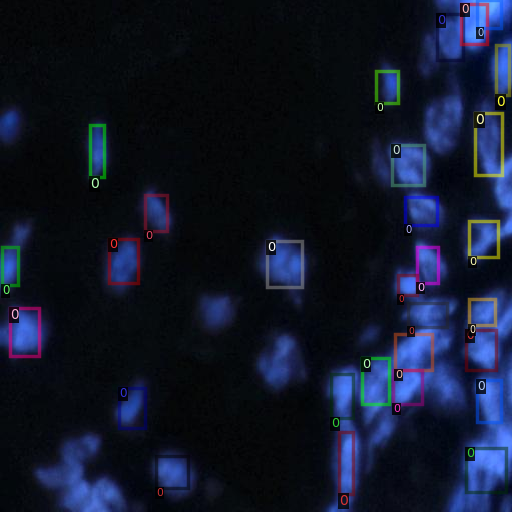

datasets/detectron2/train/AP39_4_1_9_png.rf.303e5dedcf8a83008ec4ae1f46ca745e.jpg


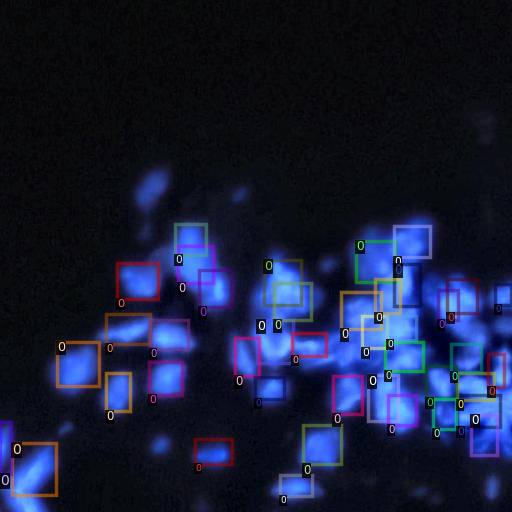

datasets/detectron2/train/AP123_4_1_4_5_png.rf.79b6018a9f2a3b5775f7e044606e4d9f.jpg


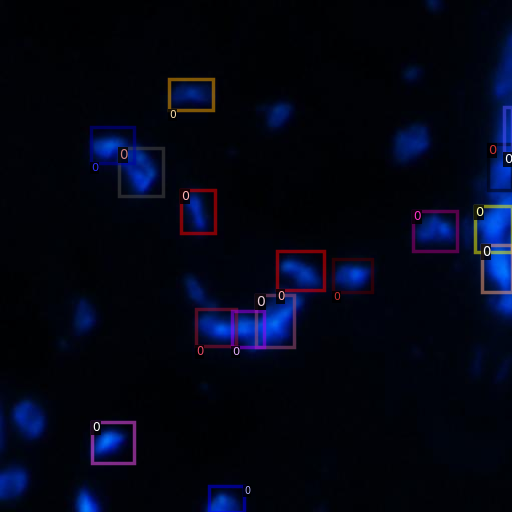

In [16]:
#visualize training data
metadata = MetadataCatalog.get("albumen_train")
dataset_dicts = DatasetCatalog.get("albumen_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Train!


In [17]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
# for cpu only
cfg.MODEL.DEVICE = 'mps'    # 'cpu' / 'cuda' (CUDA) / 'mps' (metal for Apple silicon)
cfg.PYTORCH_ENABLE_MPS_FALLBACK=1
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("albumen_train",)
cfg.DATASETS.TEST = ('albumen_valid')
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (cell). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# uncomment below to train
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[03/22 21:34:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[03/22 21:34:49 d2.engine.train_loop]: Starting training from iteration 0


/Users/cusniwtt/opt/miniconda3/envs/torch/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


ERROR [03/22 21:34:53 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/Users/cusniwtt/opt/miniconda3/envs/torch/lib/python3.9/site-packages/detectron2/engine/train_loop.py", line 155, in train
    self.run_step()
  File "/Users/cusniwtt/opt/miniconda3/envs/torch/lib/python3.9/site-packages/detectron2/engine/defaults.py", line 494, in run_step
    self._trainer.run_step()
  File "/Users/cusniwtt/opt/miniconda3/envs/torch/lib/python3.9/site-packages/detectron2/engine/train_loop.py", line 287, in run_step
    loss_dict = self.model(data)
  File "/Users/cusniwtt/opt/miniconda3/envs/torch/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Users/cusniwtt/opt/miniconda3/envs/torch/lib/python3.9/site-packages/detectron2/modeling/meta_arch/rcnn.py", line 161, in forward
    proposals, proposal_losses = self.proposal_generator(images, features, gt_instances)
  File "/User

NotImplementedError: The operator 'torchvision::nms' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.

## Or load saved model

In [ ]:
# !wget "https://mipt.one/mediafiles/models/detectron2_miptone" -o "model_final.pth"

## TensorBoard

In [ ]:
#%reload_ext tensorboard
#%tensorboard --logdir /output

## Inference & evaluation using the trained model



In [19]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[02/27 14:15:39 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


In [20]:
import pickle
with open("cfg.pkl", "wb") as f:
    pickle.dump(cfg, f)

Then, we randomly select several samples to visualize the prediction results.

[02/27 14:15:49 d2.data.datasets.coco]: Loaded 12 images in COCO format from datasets/samples/annotation/test.json


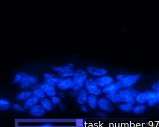

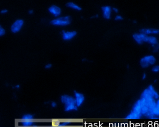

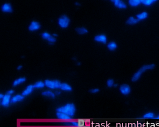

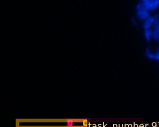

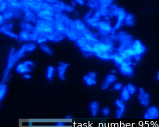

In [21]:
my_dataset_test_metadata = MetadataCatalog.get("samples_train")
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("samples_test")
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=my_dataset_test_metadata, 
                   scale=0.5, 
#                    instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~60. Not bad!

In [22]:
# fix from https://github.com/facebookresearch/detectron2/issues/2484#issuecomment-759816895

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("samples_test", ("bbox", "segm"), False, output_dir="./output/")
#evaluator = COCOEvaluator("samples_test", ("bbox", ), False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, "samples_test")
inference_on_dataset(trainer.model, test_loader, evaluator)
# another equivalent way to evaluate the model is to use `trainer.test`

[02/27 14:15:59 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[02/27 14:15:59 d2.data.datasets.coco]: Loaded 12 images in COCO format from datasets/samples/annotation/test.json
[02/27 14:15:59 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/27 14:15:59 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[02/27 14:15:59 d2.data.common]: Serializing 12 elements to byte tensors and concatenating them all ...
[02/27 14:15:59 d2.data.common]: Serialized dataset takes 0.24 MiB
[02/27 14:15:59 d2.evaluation.evaluator]: Start inference on 12 batches
[02/27 14:16:12 d2.evaluation.evaluator]: Inference done 11/12. Dataloading: 0.0003 s/iter. Inference: 0.9958 s/iter. Eval: 0.0003 s/iter. Total: 0.9964 s/iter. ETA=0:00:00
[02/27 14:16:13 d2.evaluation.evaluator]: Total inference t

OrderedDict([('bbox',
              {'AP': 0.0,
               'AP50': 0.0,
               'AP75': 0.0,
               'APs': nan,
               'APm': nan,
               'APl': 0.0}),
             ('segm',
              {'AP': 0.05940594059405942,
               'AP50': 0.19801980198019803,
               'AP75': 0.0,
               'APs': nan,
               'APm': nan,
               'APl': 0.29702970297029696})])

## Exporting trained model weights for deployment

In [ ]:
# from detectron2.modeling import build_model
# from detectron2.checkpoint import DetectionCheckpointer

# with open("cfg.pkl", "rb") as f:
#     cfg = pickle.load(f)

# model = build_model(cfg)
# DetectionCheckpointer(model).load(file_path_or_url)